# 2 Modeling

In this notebook, several models are evaluated using the data prepared on the [previous notebook](1.%20Data%20Exploration.ipynb). The performance of the models will be evaluated by means of the __MAPE__ (Mean Absolute Percentage Error) defined as,

$ MAPE = \frac {1}{n} \sum_{i=1}^{n} \left | \frac{A_i - F_i}{A_i} \right | $, where $A_i$ stands for the actual value and $F_i$ for the forecast value.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd

# select the style from fivethityeight website
mpl.rcdefaults() 
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

%matplotlib inline
mpl.rcParams['figure.figsize'] = (18, 16)
mpl.rcParams['figure.dpi'] = 80

import warnings
warnings.filterwarnings('ignore')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
df = pd.read_csv('./data/train_clean.csv', parse_dates=['date'], index_col=['date'])
df.head()

,sku,size,brand,price,exposed,volume,sales,scope,target,variation,pack_multi,pack_single
date,,,,,,,,,,,,
2016-12-17,2689,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0,23521.0,-0.027053,0.0,1.0
2016-12-24,2689,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0,22075.0,-0.061477,0.0,1.0
2016-12-31,2689,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0,16492.0,-0.252911,0.0,1.0
2017-01-07,2689,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0,0.574764,0.0,1.0
2017-01-14,2689,395.41,BRAND1,1.16,0.0,29.058565,25971.0,0,26627.0,0.025259,0.0,1.0


---

## 2.1 ARMA Model

The first evaluation will consist on the ARMA, ARMAX and ARIMA models. Since we have one time serie per product, we should create one model per product. However, this is not feasible as we have 43 different products. Thus, a possible approach is to create one model per brand, as products in the same brand seems to have similar behaviors, as it is shown below.

In [5]:
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

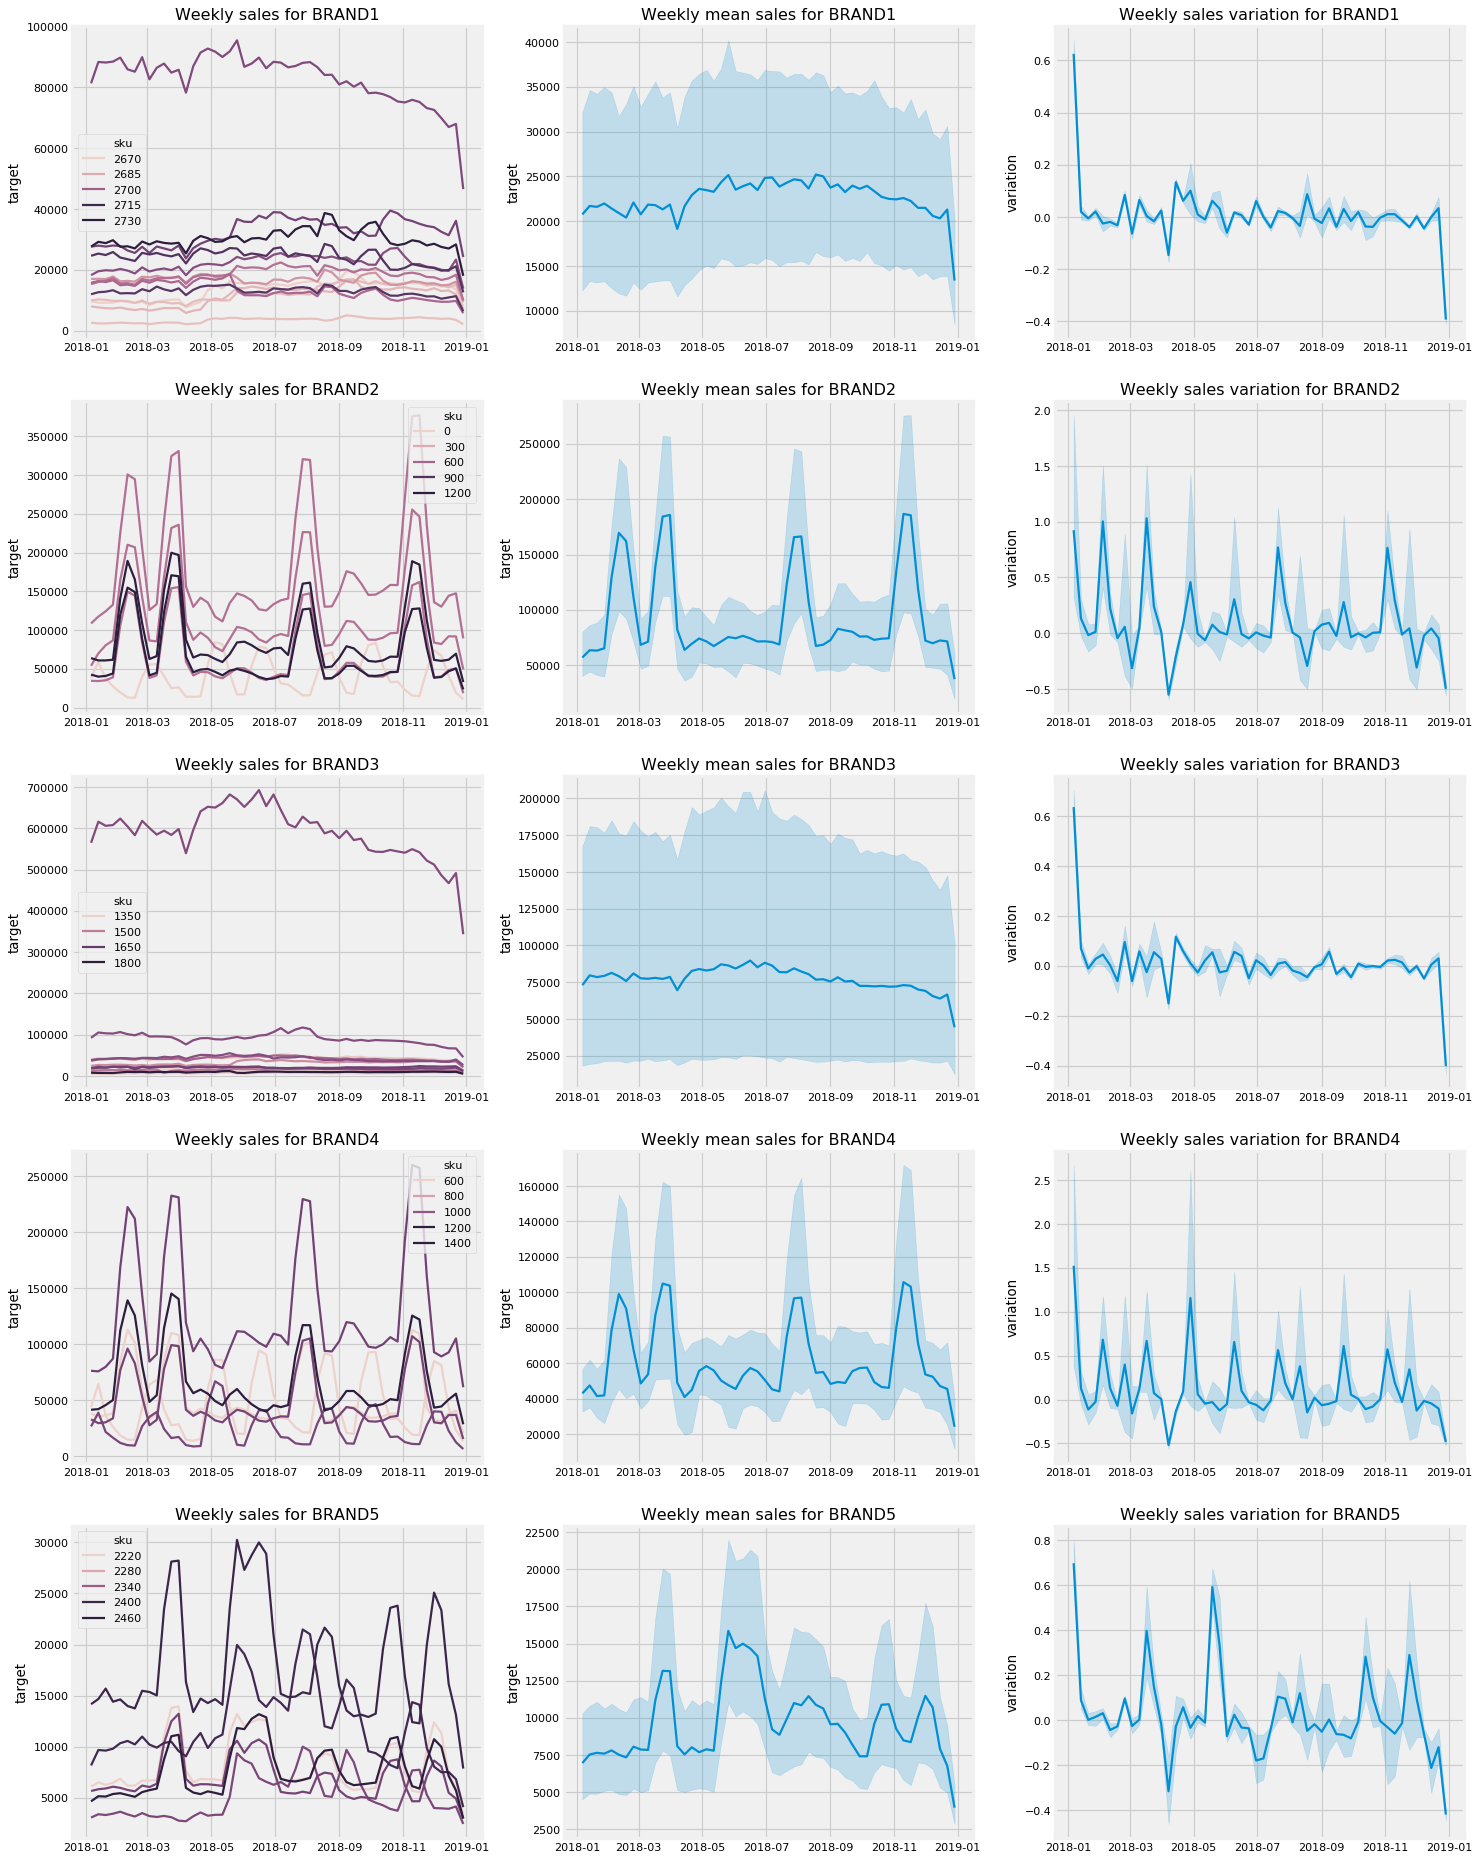

In [6]:
f, axes = plt.subplots(5, 3, figsize=(20, 30))

for brand, index in zip(df.brand.unique(), range(len(df.brand.unique()))):
    data = df[df.brand == brand]['2018']
    x = data.index.get_level_values(0).to_series().values

    sns.lineplot(x=x, y=data.target, hue=data.sku, ax=axes[index][0]).set_title("Weekly sales for {}".format(brand))
    sns.lineplot(x=x, y=data.target, ax=axes[index][1]).set_title("Weekly mean sales for {}".format(brand))
    sns.lineplot(x=x, y=data.variation, ax=axes[index][2]).set_title("Weekly sales variation for {}".format(brand))

We already noted that the weekly sales are non-stationary for some SKUs, so a better approach is using the weekly sales variation at it has been proved that it is stationary. However, when working over the brands, as we are actually working with a mean value, we should work using the variation ratio instead of the sales value, as it is a relative measure.

For this reason, in this section an ARMA model is proposed by optimizing it using a grid search, taking as input variable the weekly sales variation.

In [7]:
p, q, bic, aic, brands, err = [], [], [], [], [], []

for brand in df.brand.unique():
    print('Computing ARMA models for {}'.format(brand))
    data = df[df.brand == brand].groupby(['date', 'brand']).mean()
    for ar_order in range(5):
        for ma_order in range(5):
            # print('ARMA degrees set to ({},{})'.format(ar_order, ma_order))
            model = ARMA(data.variation, order=(ar_order, ma_order))
            try:
                result = model.fit()
            except ValueError:
                continue

            p.append(ar_order)
            q.append(ma_order)
            bic.append(result.bic)
            aic.append(result.aic)
            brands.append(brand)
            err.append(mean_absolute_percentage_error(data.variation.values, result.fittedvalues))
        
gridsearch = pd.DataFrame({'brand':brands,'AR(p)':p,'MA(q)':q,'AIC':aic,'BIC':bic,'MAPE':err})

Computing ARMA models for BRAND1
Computing ARMA models for BRAND2
Computing ARMA models for BRAND3
Computing ARMA models for BRAND4
Computing ARMA models for BRAND5


In [8]:
idx = gridsearch.groupby('brand').AIC.transform(min) == gridsearch.AIC
gridsearch[idx]

,brand,AR(p),MA(q),AIC,BIC,MAPE
19,BRAND1,3,4,-182.827708,-156.882491,2024.956128
40,BRAND2,3,3,66.592257,89.654672,546.482003
56,BRAND3,2,1,-212.281970,-197.867961,356.051517
92,BRAND4,4,3,90.513622,116.458839,730.084327
114,BRAND5,4,3,-59.865285,-33.920068,387.069873


As it can noticed, the optimum models are different for each brand. However, the MAPE error are too big. There are other models which minimizes the MAPE error but they are still really high, as shown below. Besides these models are too simpler, ARMA(0,0) some of them, which are not right predictors.

In [9]:
idx = gridsearch.groupby('brand').MAPE.transform(min) == gridsearch.MAPE
gridsearch[idx]

,brand,AR(p),MA(q),AIC,BIC,MAPE
0,BRAND1,0,0,-160.552367,-154.786763,335.769702
39,BRAND2,3,2,72.442791,92.622404,361.003086
46,BRAND3,0,0,-190.077726,-184.312122,193.671328
79,BRAND4,2,0,101.077134,112.608342,467.374825
95,BRAND5,0,1,-35.507026,-26.858620,308.778135


Instead of using the ARMA model, we are going to work with the ARIMA model that includes a pre-processing step in order to make data stationary. For computing the different models, we are going to make use of the `auto_arima` function that performs an automatically grid search.

In [10]:
orders, bic, aic, brands, err = [], [], [], [], []
models = {}

for brand in df.brand.unique():
    print('Computing ARMA models for {}'.format(brand))
    data = df[df.brand == brand].groupby(['date', 'brand']).mean()
    model = auto_arima(data.variation, start_p=1, start_q=1, max_p=3, max_q=3, m=12, 
                       seasonal=False, start_P=0, d=1, D=1, trace=False, 
                       error_action='ignore', suppress_warnings=True)
    models[brand] = model
    
    orders.append(model.get_params()['order'])
    bic.append(model.bic())
    aic.append(model.bic())
    brands.append(brand)
    err.append(mean_absolute_percentage_error(data.variation.values, model.predict(132)))
        
gridsearch = pd.DataFrame({'brand':brands,'order':orders,'AIC':aic,'BIC':bic,'MAPE':err})

Computing ARMA models for BRAND1
Computing ARMA models for BRAND2
Computing ARMA models for BRAND3
Computing ARMA models for BRAND4
Computing ARMA models for BRAND5


In [11]:
gridsearch

,brand,order,AIC,BIC,MAPE
0,BRAND1,"(0, 1, 2)",-147.364493,-147.364493,195.903518
1,BRAND2,"(3, 1, 2)",98.175064,98.175064,516.475290
2,BRAND3,"(0, 1, 2)",-189.789978,-189.789978,164.490716
3,BRAND4,"(2, 1, 2)",121.000921,121.000921,610.159986
4,BRAND5,"(2, 1, 1)",-17.936108,-17.936108,306.856329


As it can be noticed, the MAPE error for some them has decreased, but for others, it has increased. As we are using a model for each brand, we can pick the best one for each brand.

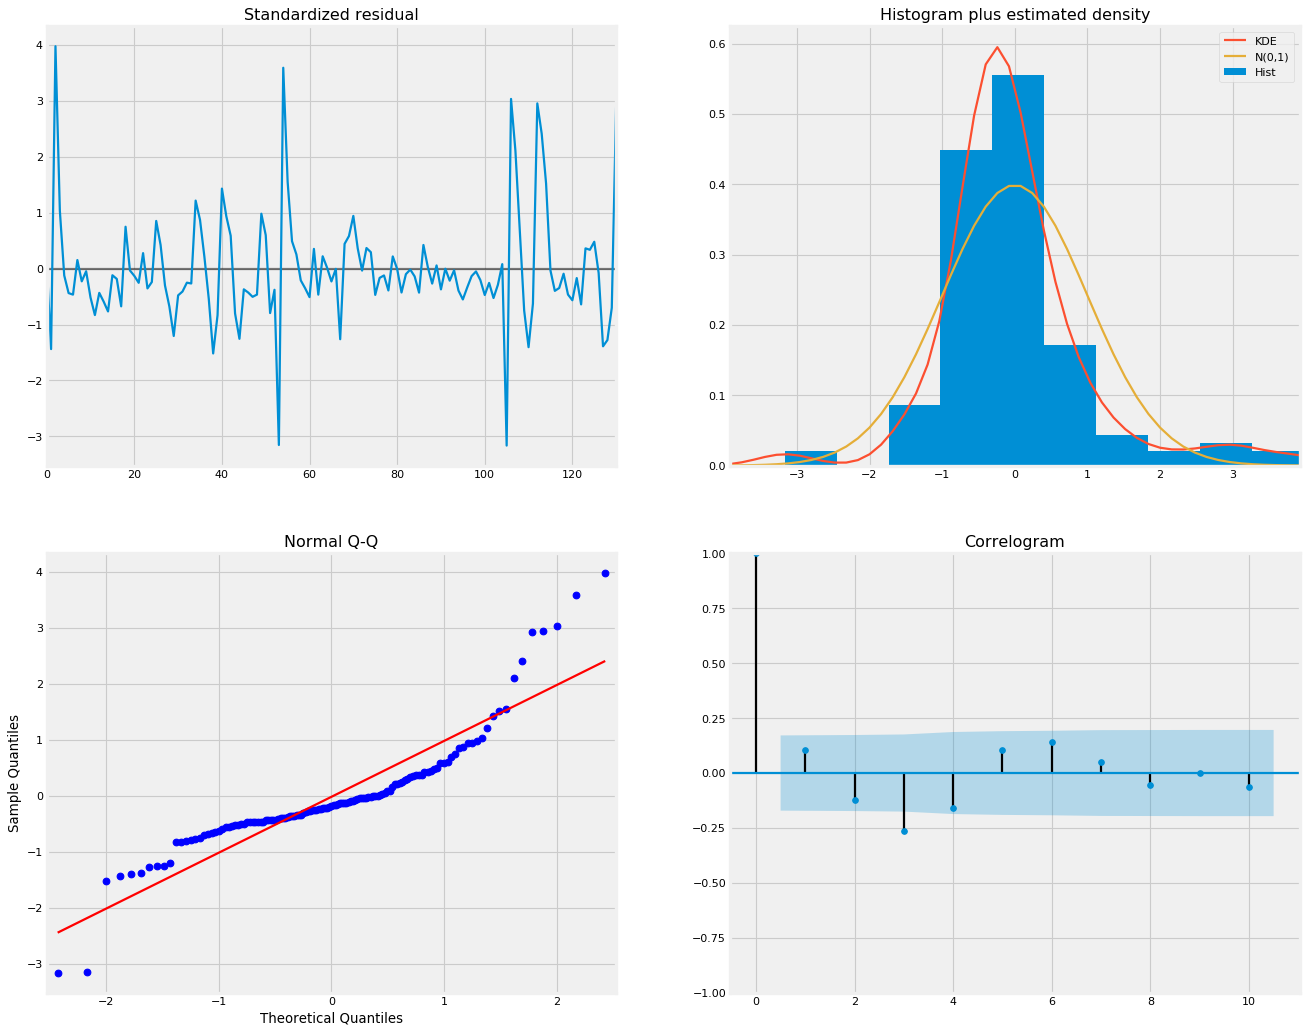

In [57]:
models['BRAND1'].plot_diagnostics()
plt.show()

Finally, when looking for the diagnostics of some models, it can be noted that, for instance the model for _BRAND3_ the distribution of the residuals follows a Gaussian distribution centered in zero, what makes sense. Besides, the correlogram shows that the model is capturing all the information of the series.

The residuals seems to have a seasonal trend. However, when computing the Dickey-Fuller test, we can note that it is almost zero, and by its correlogram and their distribution, they seem white noise and we should be satisfied.

In [56]:
print("p-value for residuals %.4g" % adfuller(models['BRAND2'].resid())[1])

p-value for residuals 4.252e-21


Thus, we are going to test the model over the different products in order to check the actual MAPE over the sales, as it is the final measure taken into account.

In [281]:
df_arima = df.dropna() # Removing rows with NaN values
df_arima = df_arima.groupby(['date', 'brand', 'sku']).sum()
df_arima

size  price  exposed      volume    sales  scope  \
date       brand  sku                                                        
2016-12-17 BRAND1 2678  105.44   1.74      0.0    3.934208  12038.0      0   
                  2681  105.44   1.73      0.0    2.999190   6175.0      0   
                  2682  105.44   1.50      0.0    1.773147   9094.0      0   
                  2683  105.44   1.74      0.0    0.948047  10192.0      0   
                  2689  395.41   1.15      1.0   17.676112  24175.0      0   
...                        ...    ...      ...         ...      ...    ...   
2019-06-22 BRAND5 2360  131.80   0.94      0.0   27.745965  10967.0      0   
                  2365  395.41   1.71      3.0  100.000000   9304.0      0   
                  2396  131.80   0.87      0.0   10.348490   6026.0      0   
                  2401  395.41   1.72      7.0  100.000000  28972.0      0   
                  2410  395.41   1.72      3.0  100.000000  12379.0      0   

                         target  variation  pack_multi  pack_single  
date       brand  sku                                                
2016-12-17 BRAND1 2678  11639.0  -0.033145         1.0          0.0  
                  2681   6103.0  -0.011660         1.0          0.0  
                  2682   8978.0  -0.012756         1.0          0.0  
                  2683   9850.0  -0.033556         1.0          0.0  
                  2689  23521.0  -0.027053         0.0          1.0  
...                         ...        ...         ...          ...  
2019-06-22 BRAND5 2360  13430.0   0.224583         0.0          1.0  
                  2365   6034.0  -0.351462         0.0          1.0  
                  2396   7949.0   0.319117         0.0          1.0  
                  2401  19356.0  -0.331907         0.0          1.0  
                  2410   8356.0  -0.324986         0.0          1.0  

[5676 rows x 10 columns]

In [282]:
for brand in df.brand.unique():
    result = pd.DataFrame(models[brand].predict(132), 
                          index=[df_arima.index.get_level_values(0).unique()], 
                          columns=['prediction'])
    result['brand'] = np.full(132, brand)
    try: 
        df_arima['prediction'].fillna(result.groupby(['date', 'brand']).sum().prediction, inplace=True)
    except:
        df_arima['prediction'] = result.groupby(['date', 'brand']).sum()

In [287]:
df_arima['forecast'] = df_arima.sales * (1 + df_arima.prediction)
df_arima.head()

size  price  exposed     volume    sales  scope  \
date       brand  sku                                                       
2016-12-17 BRAND1 2678  105.44   1.74      0.0   3.934208  12038.0      0   
                  2681  105.44   1.73      0.0   2.999190   6175.0      0   
                  2682  105.44   1.50      0.0   1.773147   9094.0      0   
                  2683  105.44   1.74      0.0   0.948047  10192.0      0   
                  2689  395.41   1.15      1.0  17.676112  24175.0      0   

                         target  variation  pack_multi  pack_single  \
date       brand  sku                                                 
2016-12-17 BRAND1 2678  11639.0  -0.033145         1.0          0.0   
                  2681   6103.0  -0.011660         1.0          0.0   
                  2682   8978.0  -0.012756         1.0          0.0   
                  2683   9850.0  -0.033556         1.0          0.0   
                  2689  23521.0  -0.027053         0.0          1.0   

                        prediction      forecast  
date       brand  sku                             
2016-12-17 BRAND1 2678   -0.143915  10305.555530  
                  2681   -0.143915   5286.327081  
                  2682   -0.143915   7785.240238  
                  2683   -0.143915   8725.221960  
                  2689   -0.143915  20695.863510

In [288]:
mean_absolute_percentage_error(df_arima.target, df_arima.forecast)

17.76468642168072

Thus, the overall MAPE error for the ARIMA model is <span style="border: 1px solid green; padding: 0px 5px; border-radius: 10px; margin: 0px 3px;"> 17.7647 </span>, so we should be satisfied. In the next plot, we can notice the forecast for several SKUs of different models.

In [302]:
df[df.sku.isin([2689, 1027, 1554, 1051, 2360])].groupby(['sku', 'brand']).mean().sort_values('brand')

,,size,price,exposed,volume,sales,scope,target,variation,pack_multi,pack_single
sku,brand,,,,,,,,,,
2689,BRAND1,395.41,1.114394,2.242424,38.492718,16411.719697,0,16332.378788,0.009072,0.0,1.0
1027,BRAND2,114.23,0.487576,6.560606,50.590094,88432.234848,1,88524.500000,0.060573,0.0,1.0
1554,BRAND3,395.41,1.034167,0.015152,4.424651,38992.545455,0,39125.742424,0.010045,0.0,1.0
1051,BRAND4,125.65,2.720076,11.075758,60.231542,25029.250000,1,24815.393939,0.221817,1.0,0.0
2360,BRAND5,131.80,0.929318,0.121212,36.437286,5697.977273,0,5781.295455,0.057447,0.0,1.0


In [375]:
def get_sku_plot_data(sku):
    data = df_arima.reset_index()[df_arima.reset_index().sku==sku][['target', 'forecast', 'date']]
    return data['date'], data['target'], data['forecast']

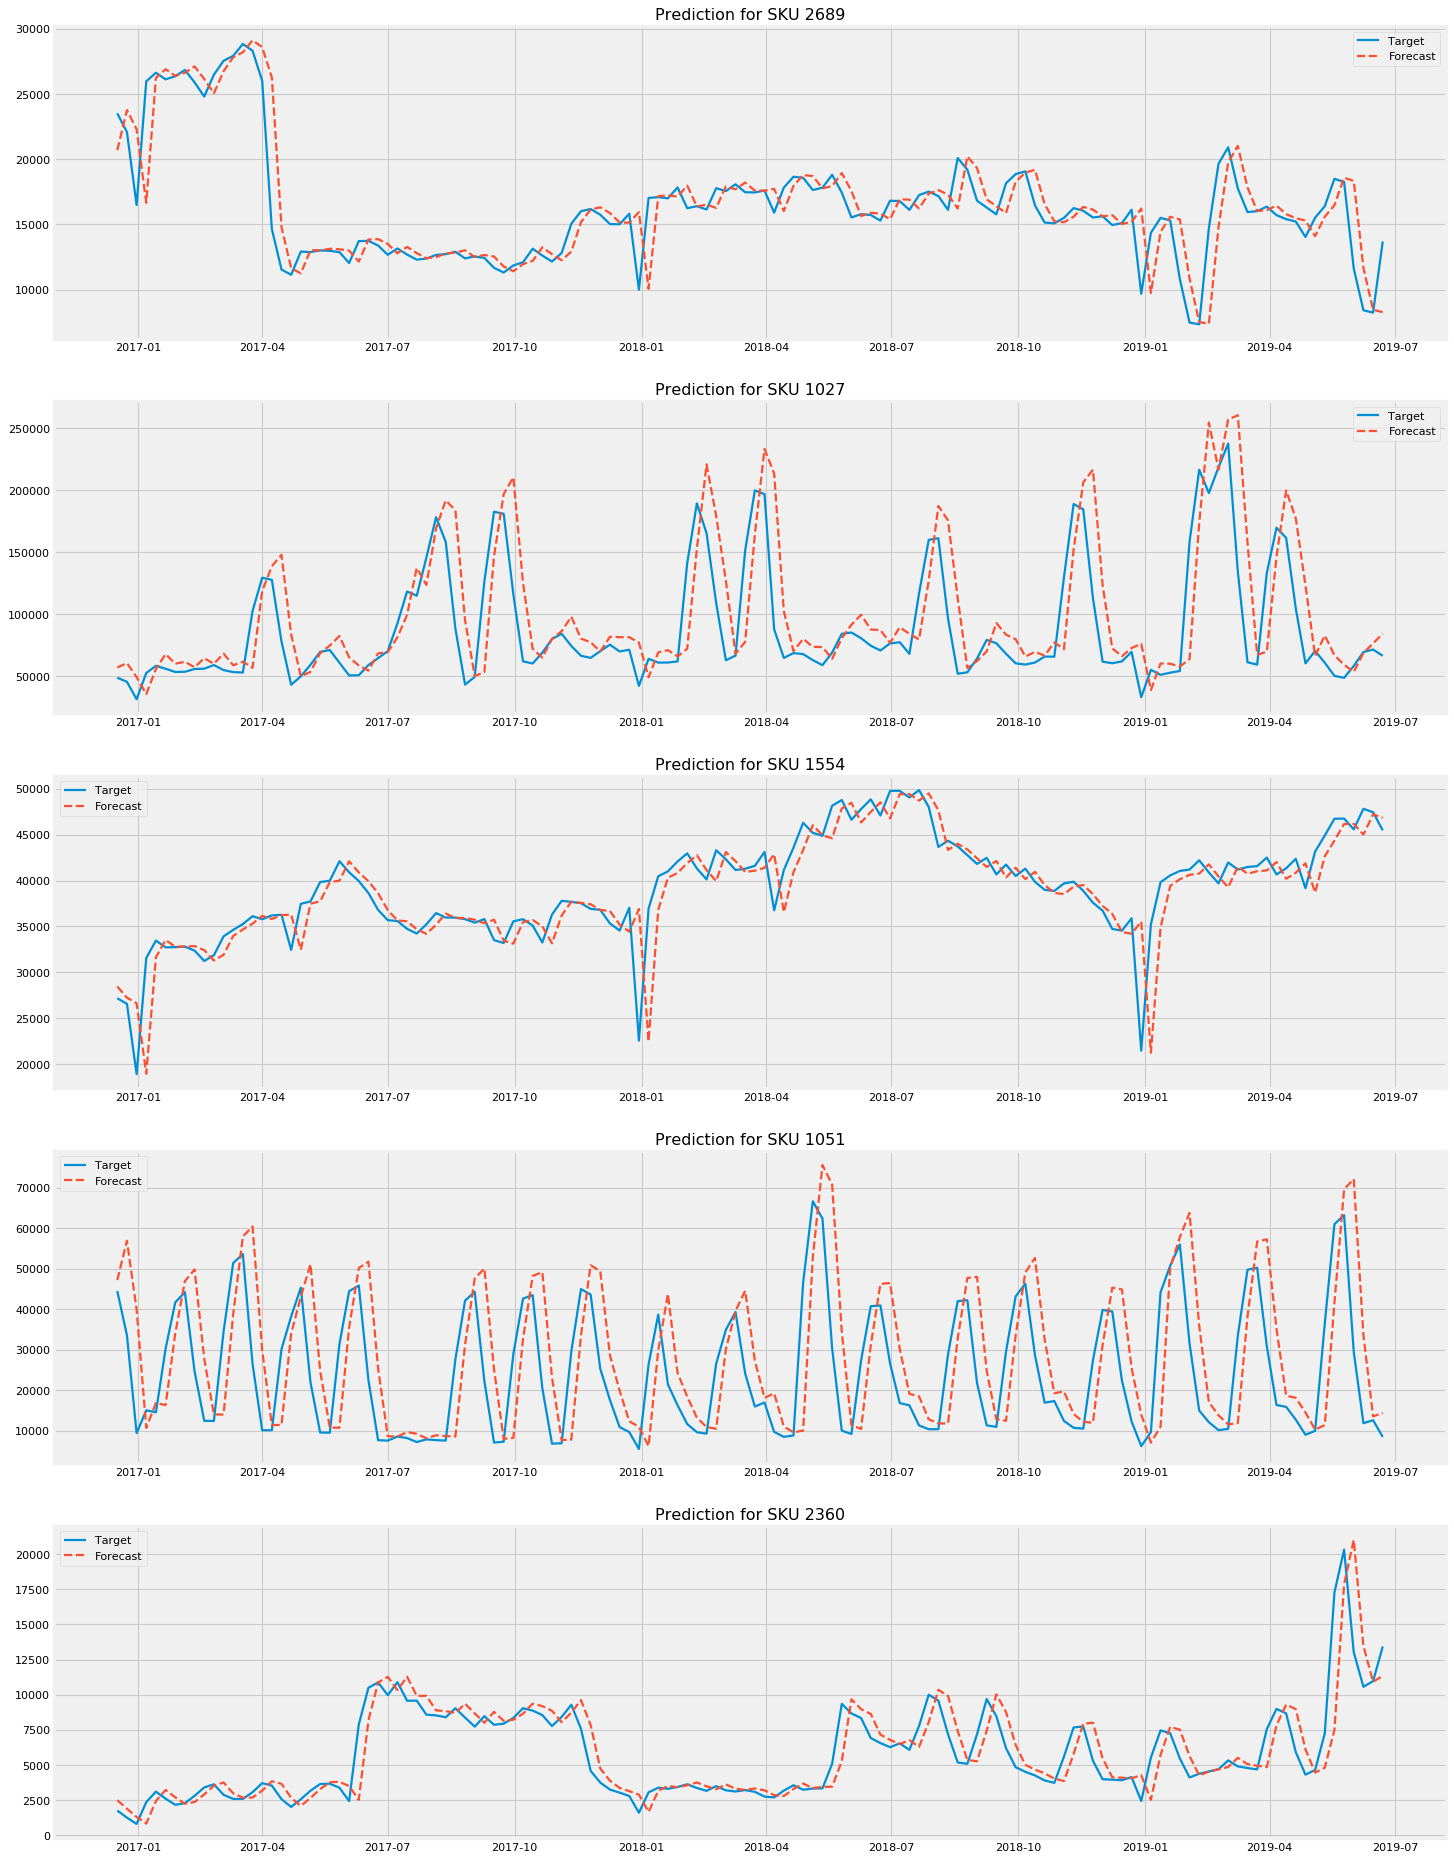

In [387]:
f, axes = plt.subplots(5, 1, figsize=(20, 30))

plt.subplot(5,1,1)
x, y1, y2 = get_sku_plot_data(2689)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 2689')
plt.legend()
plt.subplot(5,1,2)
x, y1, y2 = get_sku_plot_data(1027)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 1027')
plt.legend()
plt.subplot(5,1,3)
x, y1, y2 = get_sku_plot_data(1554)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 1554')
plt.legend()
plt.subplot(5,1,4)
x, y1, y2 = get_sku_plot_data(1051)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 1051')
plt.legend()
plt.subplot(5,1,5)
x, y1, y2 = get_sku_plot_data(2360)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 2360')
plt.legend()

---

## 2.2 Logistic Regression

In this section we are going to evaluate several approaches using Logistic Regression and optimizing it, taking into account the overfitting and other measures. For evaluating the model, we are going to use the MAPE definition and cross-validation with a k-fold of 10.